# **Find the best NBA basketball team using genetic algorithms**

When playing some games involving real players from real tournaments, it is really hard sometimes to choose the best team. <br>
In this notebook my aim is to present a basic approach for genetic algorithm to select the best team(s).

# Imports

Let's start by importing all the libraries we need

In [ ]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import random
from datetime import datetime
import time
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

We also set a seed to avoid randomness.

In [3]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# Dataset construction

Since we need to have characteristics of the NBA players we want to consider, we need to construct our dataset from scratch. <br>
To do so, the website https://hoopshype.com was used.

I started with checking the info for one player only.

In [4]:
def get_player_info(player_url):
    player_response = requests.get(player_url)
    player_soup = BeautifulSoup(player_response.content, "html.parser")
    
    player_info = {}

    try:
        bio_div = player_soup.find("div", class_="player-bio-text")

        # Extract Position
        position = bio_div.find_all("span", class_="player-bio-text-line")[0]
        player_info['role'] = position.find("span", class_="player-bio-text-line-value").text.strip()

        # Extract Date of Birth
        birth_date = bio_div.find_all("span", class_="player-bio-text-line")[1]
        player_info['birth_date'] = birth_date.find("span", class_="player-bio-text-line-value").text.strip()

        # Extract Salary
        salary = bio_div.find_all("span", class_="player-bio-text-line")[4]
        player_info['salary'] = salary.find("span", class_="player-bio-text-line-value").text.strip()
        
    except AttributeError as e:
        print(f"Error extracting info from {player_url}: {e}")
    
    return player_info

stephen_curry_url = "https://hoopshype.com/player/stephen-curry/salary/"
player_info = get_player_info(stephen_curry_url)

print("Player Info for Stephen Curry:")
print(f"Role: {player_info.get('role', 'N/A')}")
print(f"Date of Birth: {player_info.get('birth_date', 'N/A')}")
print(f"Salary: {player_info.get('salary', 'N/A')}")


Player Info for Stephen Curry:
Role: G
Date of Birth: 03/14/88
Salary: $51,915,615


Let's make it a list

In [5]:
def get_player_info(player_url):
    player_response = requests.get(player_url)
    player_soup = BeautifulSoup(player_response.content, "html.parser")
    
    player_info = []

    try:
        bio_div = player_soup.find("div", class_="player-bio-text")

        # Extract Position
        position = bio_div.find_all("span", class_="player-bio-text-line")[0]
        role = position.find("span", class_="player-bio-text-line-value").text.strip()
        player_info.append(role)

        # Extract Date of Birth
        birth_date = bio_div.find_all("span", class_="player-bio-text-line")[1]
        date_of_birth = birth_date.find("span", class_="player-bio-text-line-value").text.strip()
        player_info.append(date_of_birth)

        # Extract Salary
        salary = bio_div.find_all("span", class_="player-bio-text-line")[4]
        salary_value = salary.find("span", class_="player-bio-text-line-value").text.strip()
        player_info.append(salary_value)
        
    except AttributeError as e:
        print(f"Error extracting info from {player_url}: {e}")
    
    return player_info

stephen_curry_url = "https://hoopshype.com/player/stephen-curry/salary/"
player_info = get_player_info(stephen_curry_url)

print("Player Info for Stephen Curry:")
print(player_info)


Player Info for Stephen Curry:
['G', '03/14/88', '$51,915,615']


And then this is the code working for all players, skipping errors for players it cannot compute. Everything is saved in a csv file.

In [6]:
def calculate_age(birth_date):
    birth_date = datetime.strptime(birth_date, "%m/%d/%y")
    age = int((datetime.now() - birth_date).days / 365.25)
    return age

def get_player_info(player_url):
    player_response = requests.get(player_url)
    player_soup = BeautifulSoup(player_response.content, "html.parser")
    
    player_info = []

    try:
        bio_div = player_soup.find("div", class_="player-bio-text")

        position = bio_div.find_all("span", class_="player-bio-text-line")[0]
        role = position.find("span", class_="player-bio-text-line-value").text.strip()
        player_info.append(role)

        birth_date = bio_div.find_all("span", class_="player-bio-text-line")[1]
        date_of_birth = birth_date.find("span", class_="player-bio-text-line-value").text.strip()
        age = calculate_age(date_of_birth)
        player_info.append(age)

        salary = bio_div.find_all("span", class_="player-bio-text-line")[4]
        salary_value = salary.find("span", class_="player-bio-text-line-value").text.strip()
        player_info.append(salary_value)
        
    except AttributeError as e:
        print(f"Error extracting info from {player_url}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred for player at {player_url}: {e}")
        return None
    
    return player_info


base_url = "https://hoopshype.com"

url = "https://hoopshype.com/nba2k/"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

all_players_info = []

for row in soup.select("table tbody tr"):
    cols = row.find_all("td")
    if len(cols) > 2:
        player_name = cols[1].text.strip()
        
        try:
            relative_url = cols[1].find("a")["href"]
        except TypeError as te:
            print(f"Skipping player {player_name} due to TypeError: {te}")
            continue
        
        player_page_url = base_url + relative_url
        
        if player_name in ["Cameron Whitmore", "Jaren Jackson Jr."]:
            print(f"Skipping player {player_name}")
            continue

        player_info = get_player_info(player_page_url)
        
        if player_info:
            player_info.insert(0, player_name)
            player_info.insert(1, cols[2].text.strip())
            
            all_players_info.append(player_info)
            
            print(f"Player {player_name} done")
        
        time.sleep(1)

columns = ["Name", "Rating", "Role", "Age", "Salary"]
df = pd.DataFrame(all_players_info, columns=columns)

df.to_csv("nba2k24_ratings_with_info_updated.csv", index=False)

print("Data saved to nba2k24_ratings_with_info_updated.csv")


Player Nikola Jokic done
Player Giannis Antetokounmpo done
Player Stephen Curry done
Player Kevin Durant done
Player Joel Embiid done
Player LeBron James done
Player Jimmy Butler done
Player Luka Doncic done
Player Jayson Tatum done
Player Devin Booker done
Player Kawhi Leonard done
Player Damian Lillard done
Player Anthony Davis done
Player Shai Gilgeous-Alexander done
Player Donovan Mitchell done
Player Ja Morant done
Player Kyrie Irving done
Player Zion Williamson done
Player Jaylen Brown done
Player Paul George done
Player James Harden done
Player Trae Young done
Player Jalen Brunson done
Player Anthony Edwards done
Player De'Aaron Fox done
Player Tyrese Haliburton done
Player Jamal Murray done
Player Bam Adebayo done
Player Jrue Holiday done
Player Domantas Sabonis done
Player LaMelo Ball done
Player Bradley Beal done
Player Mikal Bridges done
Player DeMar DeRozan done
Player Darius Garland done
Error extracting info from https://hoopshype.com/player/jaren-jackson-jr/2k/: 'NoneTyp

In [7]:
df

,Name,Rating,Role,Age,Salary
0,Nikola Jokic,98,C,29,"$47,607,350"
1,Giannis Antetokounmpo,96,F-G,29,"$45,640,084"
2,Stephen Curry,96,G,36,"$51,915,615"
3,Kevin Durant,96,F,35,"$47,649,433"
4,Joel Embiid,96,C,30,"$47,607,350"
...,...,...,...,...,...
494,Xavier Moon,67,G,29,"$489,005"
495,Dereon Seabron,67,F,23,"$559,782"
496,Ibou Badji,67,G,21,"$466,485"
497,John Butler,67,-,21,"$147,988"


The final dataframe contains the informations I thought were more relevant for the purposes of this project: age, salary, ranking and role.

## **Quick Exploratory Data Analysis**

Let's analyze our dataframe to understand better what to do (i.e. how to use the informations we have to implement a genetic algorithm). <br>
Since the purpose of this project is not to do Exploratory Data Analysis on the dataset, we will just focus on age compared to some other characteristics of the player. <br>
In fact, if it is pretty straightforward how to use "value" and "salary" and also the role of the player in our algorithm, it it not entirely clear how we could use the age.

Let's see our dataframe.

In [10]:
df = pd.read_csv('nba2k24_ratings.csv')
print(df)

                      Name  Rating Role  Age       Salary
0             Nikola Jokic      98    C   29  $47,607,350
1    Giannis Antetokounmpo      96  F-G   29  $45,640,084
2            Stephen Curry      96    G   36  $51,915,615
3             Kevin Durant      96    F   35  $47,649,433
4              Joel Embiid      96    C   30  $47,607,350
..                     ...     ...  ...  ...          ...
494            Xavier Moon      67    G   29     $489,005
495         Dereon Seabron      67    F   23     $559,782
496             Ibou Badji      67    G   21     $466,485
497            John Butler      67    -   21     $147,988
498          Stanley Umude      67    G   25   $1,098,242

[499 rows x 5 columns]


We need to transform the salary in an integer number to be able to use it for our measures.

In [11]:
df['Salary'] = df['Salary'].replace('[\$,]', '', regex=True).astype(int)

In [12]:
df

,Name,Rating,Role,Age,Salary
0,Nikola Jokic,98,C,29,47607350
1,Giannis Antetokounmpo,96,F-G,29,45640084
2,Stephen Curry,96,G,36,51915615
3,Kevin Durant,96,F,35,47649433
4,Joel Embiid,96,C,30,47607350
...,...,...,...,...,...
494,Xavier Moon,67,G,29,489005
495,Dereon Seabron,67,F,23,559782
496,Ibou Badji,67,G,21,466485
497,John Butler,67,-,21,147988


Now, let's plot age against salary to see how they are related. 

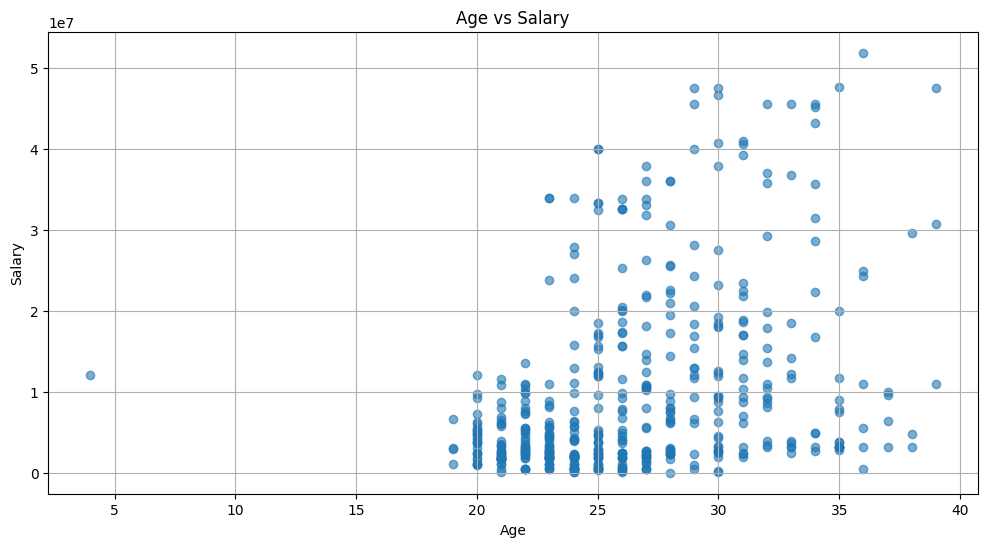

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Age'], df['Salary'], alpha=0.6)
plt.title('Age vs Salary')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.grid(True)

We can see that, (except for the error with one player, of whom we'll find later the name) the less experienced the player, the less salary he has. <br>
We don't find any other relevant pattern except for it, maybe it could be useful to plot the value assigned to a player with respect to the age.

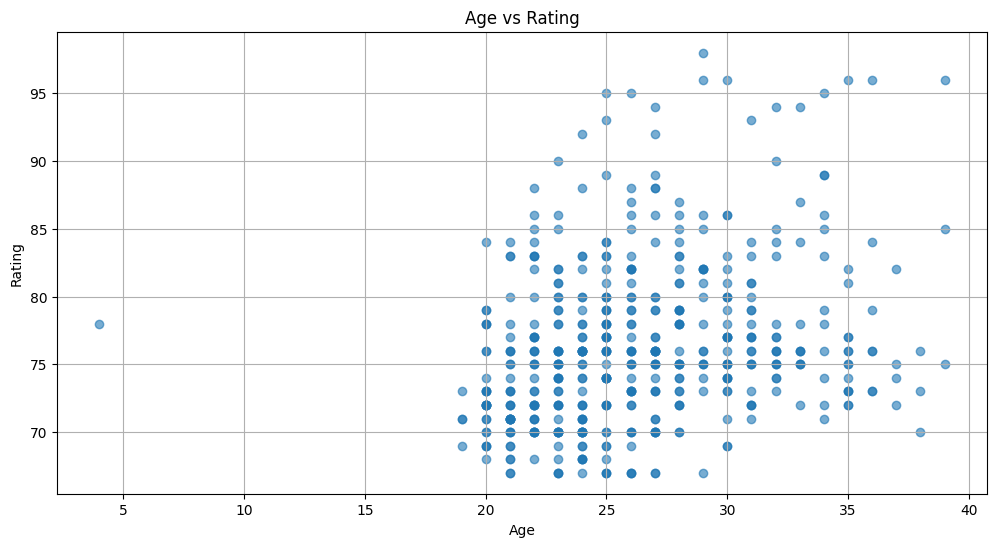

In [14]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Age'], df['Rating'], alpha=0.6)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.grid(True)

We can see that the top value is reached by a player at the age of 29. However, also some older players have relaly good values. <br>
Let's say that a player reaches its top form between 25 and 30. We'll see later why this might be useful.

Let's see now who was the player with an age that was obviously msicalculated:

In [15]:
def get_players_by_age(age):
    players = df[df['Age'] == age]['Name']
    return players.tolist()

age = 4
players_with_age_4 = get_players_by_age(age)
print(f"Players with age {age}: {players_with_age_4}")

Players with age 4: ['James Wiseman']


Checking his real age, we adjust it and see the real plots:

In [16]:
df.loc[df['Name'] == 'James Wiseman', 'Age'] = 23

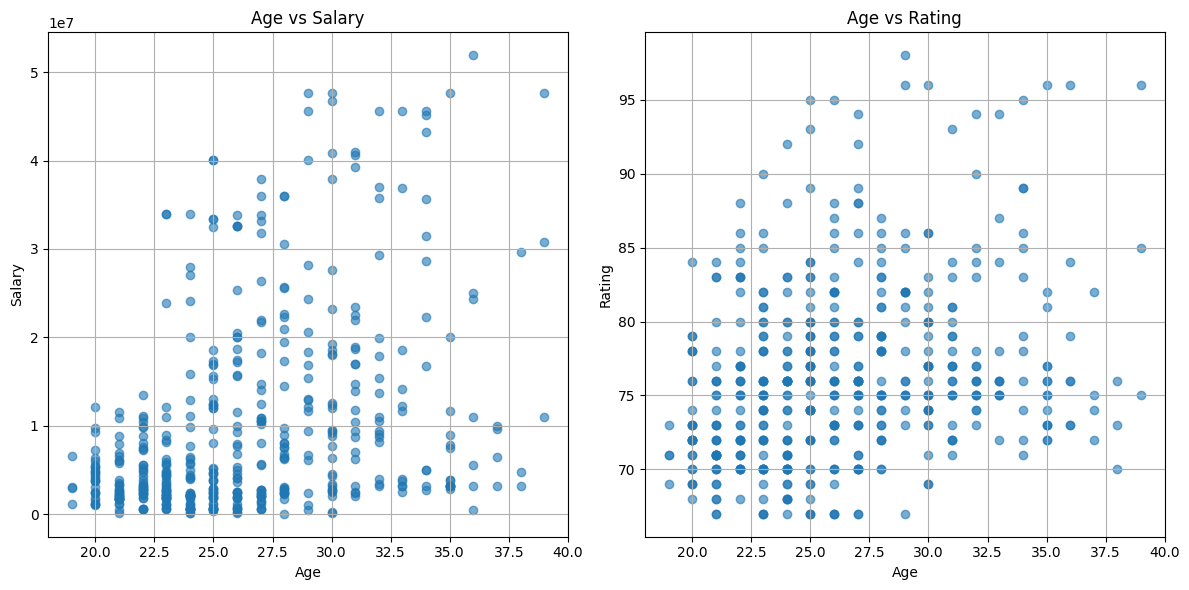

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['Age'], df['Salary'], alpha=0.6)
plt.title('Age vs Salary')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df['Age'], df['Rating'], alpha=0.6)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.grid(True)

plt.tight_layout()
plt.show()


Let's finally see how the players' age is distributed

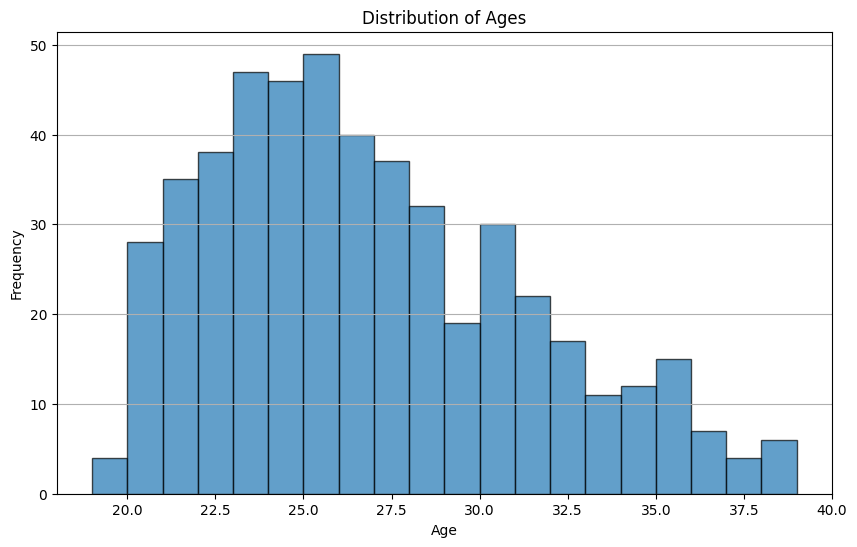

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=range(df['Age'].min(), df['Age'].max() + 1), edgecolor='black', alpha=0.7)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.show()

Let's move on now to the actual implementation of the algorithm.

Now that we saw how are data is distributed, we now how to treat the different characteristics of our players:
- the salary will be useful to set a limit, a bound for the total cost of the team
- the age will have different "scores" based on the interval it is in: 19-24 lower score, 25-32 best score, >32 middle.
- the rating value will be used as it is
- for the position, it will be important to create our teams with the necessary number of players for each role.

# **Genetic Algorithm**

### **Fitness function**

Let's start with our fitness function.

We are starting from the simple value assigned from the NBA ranking for each player. <br>
We are then penalizing them for having an age higher than 32 (-5), and penalizing more if they are too inexperienced (-10). <br>
We compute the total fitness and the total salary and check if it is below the maximum one, case in which we assign the lowest possible score (- $\infty$)
We finally add a constraint for the roles in the team, again assigning the lowest score if it is not satisfied.

In [20]:
def fitness(team, player_data, max_salary):
    total_fitness = 0
    total_salary = 0
    total_age = 0
    penalty = 0
    
    for player_name in team:
        try:
            player_row = player_data[player_data['Name'] == player_name].iloc[0]
            rating = player_row['Rating']
            salary = player_row['Salary']
            age = player_row['Age']
        except IndexError as e:
            print(f"IndexError: {e} for player_name: {player_name}")
            continue
        
        player_value = rating  
        
        if age < 24:
            player_value -= 10  
        elif age > 32:
            player_value -= 5  
        
        total_fitness += player_value
        total_salary += salary
        total_age += age
    
    if total_salary > max_salary:
        return -float('inf')  
    
    role_counts = {'G': 0, 'F': 0, 'C': 0}
    for player_name in team:
        try:
            roles = player_data[player_data['Name'] == player_name].iloc[0]['Role'].split('-')
        except IndexError as e:
            print(f"IndexError: {e} for player_name: {player_name}")
            continue
        
        for role in roles:
            role_counts[role] += 1
    
    optimal_counts = {'G': 2, 'F': 2, 'C': 1}
    for role, optimal_count in optimal_counts.items():
        actual_count = role_counts.get(role, 0)
        if actual_count != optimal_count:
            penalty += abs(actual_count - optimal_count) * 100 
    
    final_fitness = total_fitness - penalty
    
    if not np.isfinite(final_fitness):
        print(f"Non-finite fitness value: {final_fitness} for team {team}")
        return -float('inf')
    
    return final_fitness

### **Initialization function**

Let's define now our initialization function which chooses a population of random teams for the genetic algorithm.

In [21]:
def initialize_population(df, population_size, team_size):
    optimal_counts = {'G': 2, 'F': 2, 'C': 1}
    population = []
    
    for _ in range(population_size):
        team = []
        role_counts = {'G': 0, 'F': 0, 'C': 0}
        
        while len(team) < team_size:
            player = df.sample(1).iloc[0]
            roles = player['Role'].split('-')
            for role in roles:
                if role in optimal_counts and role_counts[role] < optimal_counts[role]:
                    team.append(player['Name'])
                    role_counts[role] += 1
                    break
        
        # Ensure the team meets the role requirements
        if all(role_counts[role] == optimal_counts[role] for role in optimal_counts):
            population.append(team)
        else:
            print(f"Generated team does not meet role requirements: {role_counts}")

    return population

### **Crossover function**

We define the crossover function, which takes two parent teams, performs a crossover at a randomly chosen point, and creates two child teams.

In [22]:
def one_point_crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + [p for p in parent2 if p not in parent1[:crossover_point]]
    child2 = parent2[:crossover_point] + [p for p in parent1 if p not in parent2[:crossover_point]]
    
    child1 = child1[:5]
    child2 = child2[:5]
    return child1, child2

### **Swap function**

The swap function we define takes a list of offspring teams and, with a mutation rate we will define later, swaps two random players within each team.

In [23]:
def swap_mutation(offspring, mutation_rate):
    for team in offspring:
        if random.random() < mutation_rate:
            swap_indices = random.sample(range(len(team)), 2)
            team[swap_indices[0]], team[swap_indices[1]] = team[swap_indices[1]], team[swap_indices[0]]
            
        team = team[:5]
    return offspring

### **Replacement function**

This function replaces a portion of the current population with the best offspring based on their fitness scores. 

In [24]:
def replacement(population, offspring, replacement_rate):
    num_replacements = int(len(population) * replacement_rate)
    population.sort(key=lambda team: fitness(team, df, max_salary))
    offspring.sort(key=lambda team: fitness(team, df, max_salary), reverse=True)
    population[-num_replacements:] = offspring[:num_replacements]
    return population

## **Selection functions**

Let's define now the different functions we'll use to perform the selection.

### **Tournament selection**

A few individuals are chosen randomly, and the one with the highest fitness is selected. This process is repeated to select more individuals.

In [25]:
def tournament_selection(population, tournament_size):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(population, tournament_size)
        tournament_fitness = [fitness(team, df, max_salary) for team in tournament]
        selected.append(tournament[tournament_fitness.index(max(tournament_fitness))])
    return selected

### **Roulette wheel selection**

Individuals are selected based on their fitness proportion. Higher fitness individuals have a higher chance of being selected.

In [26]:
def roulette_wheel_selection(population, tournament_size):
    total_fitness = sum(fitness(team, df, max_salary) for team in population)
    selection_probs = [fitness(team, df, max_salary) / total_fitness for team in population]
    
    selected = []
    for _ in range(len(population)):
        selected.append(random.choices(population, weights=selection_probs, k=1)[0])
    return selected

### **Rank-based selection**

Individuals are ranked based on their fitness, and selection probabilities are assigned based on ranks instead of raw fitness values.

In [46]:
def rank_selection(population, tournament_size):
    sorted_population = sorted(population, key=lambda x: fitness(x, df, max_salary), reverse=True)
    total_fitness = sum(fitness(team, df, max_salary) for team in sorted_population)
    if not np.isfinite(total_fitness) or total_fitness == 0:
        return []
    selection_probs = [fitness(team, df, max_salary) / total_fitness for team in sorted_population]
    selected = np.random.choice(sorted_population, size=len(population), replace=True, p=selection_probs)
    return selected

### **Stochastic Universal Sampling**

A variation of roulette wheel selection that ensures a more even spread of selected individuals by using equally spaced pointers.

In [28]:
def stochastic_universal_sampling(population, tournament_size):
    total_fitness = sum(fitness(team, df, max_salary) for team in population)
    selection_probs = [fitness(team, df, max_salary) / total_fitness for team in population]
    
    pointers = [(i + random.random()) / len(population) for i in range(len(population))]
    pointers.sort()
    
    selected = []
    cumulative_sum = 0
    for i in range(len(population)):
        cumulative_sum += selection_probs[i]
        while pointers and cumulative_sum >= pointers[0]:
            selected.append(population[i])
            pointers.pop(0)
    return selected

## **Running the GA**

Let's define a simple function to run the algorithm. We define it in a way such that it can be used for a single run but also allowing more, to perform later GridSearch with the same function. <br>
We can immediately define the salary cap and the team size. <br>
I choose the salary cap based on the actual cap of NBA team of 2024, and for now we'll only focus on teams of 5 players (no reserves). <br>

It would be interesting to also adapt to the fact that a roster can be composed by up to 16 players during NBA regular season, and in fact we could use almost the same model, with some changes in the fitness function.

In [29]:
def run_ga(parameters, selection_function, df, max_salary=136000000, team_size=5):
    if all(isinstance(param, (int, float)) for param in parameters):
        parameters = [parameters]

    results = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(run_single_iteration(param_set, selection_function)) for param_set in parameters]

        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing combination: {e}")

    return results

In [30]:
def run_single_iteration(params, iteration_index, total_iterations):
    population_size, num_generations, tournament_size, mutation_rate, replacement_rate, selection_function, df, max_salary, team_size = params

    print(f"Starting iteration {iteration_index}/{total_iterations} with params: Population Size={population_size}, Num Generations={num_generations}, Tournament Size={tournament_size}, Mutation Rate={mutation_rate}, Replacement Rate={replacement_rate}")

    population = initialize_population(df, population_size, team_size)
    best_solution = None
    best_fitness = float('-inf')
    
    for generation in range(num_generations):
        selected_parents = selection_function(population, tournament_size)
        offspring = []
        for i in range(0, len(selected_parents), 2):
            if i + 1 < len(selected_parents):
                offspring1, offspring2 = one_point_crossover(selected_parents[i], selected_parents[i + 1])
                offspring.append(offspring1)
                offspring.append(offspring2)
        mutated_offspring = swap_mutation(offspring, mutation_rate)
        population = replacement(population, mutated_offspring, replacement_rate)
        
        for team in population:
            team_fitness = fitness(team, df, max_salary)
            if team_fitness > best_fitness:
                best_fitness = team_fitness
                best_solution = team
                print(f"New best fitness: {best_fitness} at generation {generation}")

    print(f"Finished iteration with best fitness: {best_fitness}")
    return (population_size, num_generations, tournament_size, mutation_rate, replacement_rate, best_fitness, best_solution)

Let's try what happens with some random parameters we set in advance: <br>

- Population size: 50 <br>
- Number of generations: 100 <br>
- Tournament_size: 50 <br>
- Mutation_rate: 0.1 <br>
- Replacement_rate: 0.3 <br>
As we said, the salary cap and the team size are fixed.

We can try it with different selection functions, to see if they perform differently:

In [32]:
results = []

In [33]:
single_params = (50, 100, 5, 0.1, 0.3)
max_salary = 136000000
team_size = 5
result1 = run_single_iteration(single_params + (rank_selection, df, 136000000, 5), 1, 1)
results.append(result1)

Starting iteration 1/1 with params: Population Size=50, Num Generations=100, Tournament Size=5, Mutation Rate=0.1, Replacement Rate=0.3
New best fitness: 55 at generation 0
New best fitness: 60 at generation 0
New best fitness: 146 at generation 0
New best fitness: 161 at generation 0
New best fitness: 164 at generation 0
New best fitness: 165 at generation 0
New best fitness: 167 at generation 0
New best fitness: 170 at generation 0
New best fitness: 179 at generation 0
New best fitness: 189 at generation 0
New best fitness: 196 at generation 0
New best fitness: 235 at generation 0
New best fitness: 249 at generation 0
New best fitness: 252 at generation 0
New best fitness: 255 at generation 0
New best fitness: 256 at generation 0
New best fitness: 257 at generation 0
New best fitness: 260 at generation 0
New best fitness: 264 at generation 0
New best fitness: 265 at generation 0
New best fitness: 267 at generation 0
New best fitness: 270 at generation 0
New best fitness: 274 at gener

In [34]:
result2 = run_single_iteration(single_params + (tournament_selection, df, 136000000, 5), 1, 1)
results.append(result2)

Starting iteration 1/1 with params: Population Size=50, Num Generations=100, Tournament Size=5, Mutation Rate=0.1, Replacement Rate=0.3
New best fitness: -33 at generation 0
New best fitness: 75 at generation 0
New best fitness: 140 at generation 0
New best fitness: 146 at generation 0
New best fitness: 158 at generation 0
New best fitness: 175 at generation 0
New best fitness: 182 at generation 0
New best fitness: 230 at generation 0
New best fitness: 233 at generation 0
New best fitness: 242 at generation 0
New best fitness: 246 at generation 0
New best fitness: 247 at generation 0
New best fitness: 249 at generation 0
New best fitness: 251 at generation 0
New best fitness: 254 at generation 0
New best fitness: 255 at generation 0
New best fitness: 256 at generation 0
New best fitness: 257 at generation 0
New best fitness: 259 at generation 0
New best fitness: 260 at generation 0
New best fitness: 262 at generation 0
New best fitness: 264 at generation 0
New best fitness: 265 at gene

In [35]:
result3 = run_single_iteration(single_params + (roulette_wheel_selection, df, 136000000, 5), 1, 1)
results.append(result3)

Starting iteration 1/1 with params: Population Size=50, Num Generations=100, Tournament Size=5, Mutation Rate=0.1, Replacement Rate=0.3
New best fitness: 73 at generation 0
New best fitness: 130 at generation 0
New best fitness: 132 at generation 0
New best fitness: 137 at generation 0
New best fitness: 161 at generation 0
New best fitness: 172 at generation 0
New best fitness: 175 at generation 0
New best fitness: 215 at generation 0
New best fitness: 224 at generation 0
New best fitness: 235 at generation 0
New best fitness: 243 at generation 0
New best fitness: 244 at generation 0
New best fitness: 249 at generation 0
New best fitness: 251 at generation 0
New best fitness: 252 at generation 0
New best fitness: 257 at generation 0
New best fitness: 259 at generation 0
New best fitness: 261 at generation 0
New best fitness: 262 at generation 0
New best fitness: 266 at generation 0
New best fitness: 269 at generation 0
New best fitness: 277 at generation 0
New best fitness: 278 at gene

In [36]:
result4 = run_single_iteration(single_params + (stochastic_universal_sampling, df, 136000000, 5), 1, 1)
results.append(result4)

Starting iteration 1/1 with params: Population Size=50, Num Generations=100, Tournament Size=5, Mutation Rate=0.1, Replacement Rate=0.3
New best fitness: 70 at generation 0
New best fitness: 133 at generation 0
New best fitness: 150 at generation 0
New best fitness: 161 at generation 0
New best fitness: 162 at generation 0
New best fitness: 165 at generation 0
New best fitness: 166 at generation 0
New best fitness: 173 at generation 0
New best fitness: 178 at generation 0
New best fitness: 180 at generation 0
New best fitness: 186 at generation 0
New best fitness: 194 at generation 0
New best fitness: 234 at generation 0
New best fitness: 245 at generation 0
New best fitness: 247 at generation 0
New best fitness: 250 at generation 0
New best fitness: 251 at generation 0
New best fitness: 253 at generation 0
New best fitness: 258 at generation 0
New best fitness: 265 at generation 0
New best fitness: 267 at generation 0
New best fitness: 268 at generation 0
New best fitness: 269 at gene

Let's plot the results (with the best fitness found) together to see if the different functions perform differently.

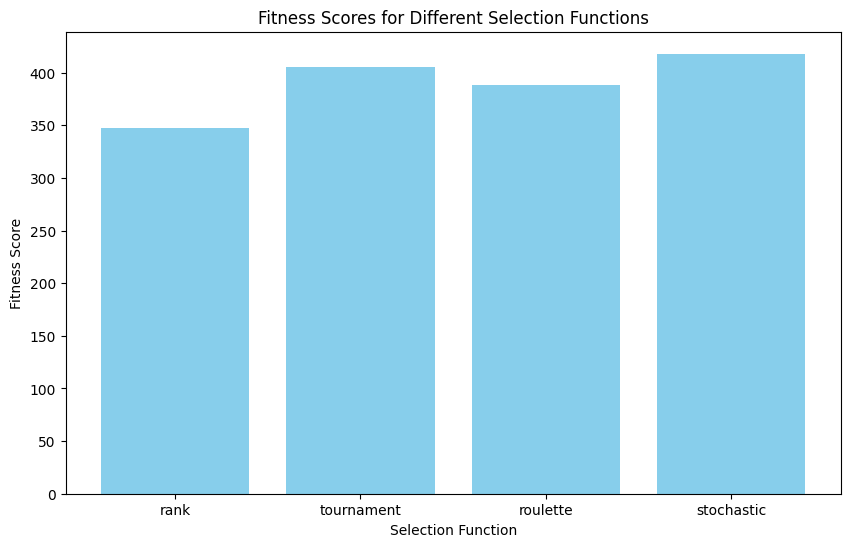

In [37]:
selection_functions = ['rank', 'tournament', 'roulette', 'stochastic']

fitness_scores = [result[5] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(selection_functions, fitness_scores, color='skyblue')
plt.xlabel('Selection Function')
plt.ylabel('Fitness Score')
plt.title('Fitness Scores for Different Selection Functions')
plt.show()

However, it would be wrong to derive conclusions just from this first trial with randomly chosen parameters: let's see what happens if we change them.

In [47]:
results = []
single_params = (100, 200, 3, 0.01, 0.5)
max_salary = 136000000
team_size = 5
result5 = run_single_iteration(single_params + (rank_selection, df, 136000000, 5), 1, 1)
results.append(result5)
result6 = run_single_iteration(single_params + (tournament_selection, df, 136000000, 5), 1, 1)
results.append(result6)
result7 = run_single_iteration(single_params + (roulette_wheel_selection, df, 136000000, 5), 1, 1)
results.append(result7)
result8 = run_single_iteration(single_params + (stochastic_universal_sampling, df, 136000000, 5), 1, 1)
results.append(result8)

Starting iteration 1/1 with params: Population Size=100, Num Generations=200, Tournament Size=3, Mutation Rate=0.01, Replacement Rate=0.5
New best fitness: -33 at generation 0
New best fitness: 55 at generation 0
New best fitness: 60 at generation 0
New best fitness: 75 at generation 0
New best fitness: 140 at generation 0
New best fitness: 146 at generation 0
New best fitness: 158 at generation 0
New best fitness: 161 at generation 0
New best fitness: 164 at generation 0
New best fitness: 165 at generation 0
New best fitness: 167 at generation 0
New best fitness: 170 at generation 0
New best fitness: 175 at generation 0
New best fitness: 179 at generation 0
New best fitness: 182 at generation 0
New best fitness: 189 at generation 0
New best fitness: 196 at generation 0
New best fitness: 230 at generation 0
New best fitness: 233 at generation 0
New best fitness: 235 at generation 0
New best fitness: 242 at generation 0
New best fitness: 246 at generation 0
New best fitness: 247 at gene

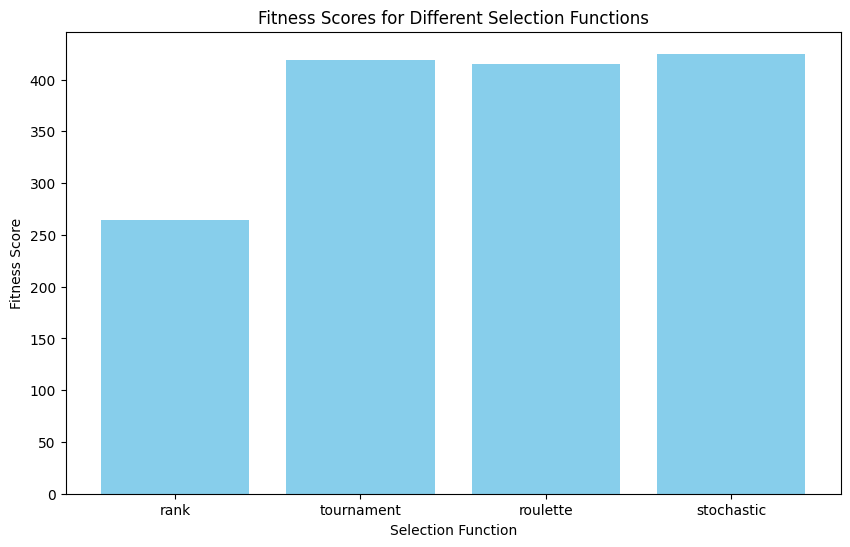

In [48]:
selection_functions = ['rank', 'tournament', 'roulette', 'stochastic']

fitness_scores = [result[5] for result in results]

plt.figure(figsize=(10, 6))
plt.bar(selection_functions, fitness_scores, color='skyblue')
plt.xlabel('Selection Function')
plt.ylabel('Fitness Score')
plt.title('Fitness Scores for Different Selection Functions')
plt.show()

We can see again some differences between the different selection functions. <br>
Compared to the result we obtained before, stochastic universal sampling is still performing better, but not as much better as before compareìd to roulette wheel and tournament selection. Rank selection got worse. <br>
So, we understand that changing the parameters can change a lot the performance of our algorithm. 

Let's then extend it to two choices per parameter and perform GridSearch with all the selection functions. <br>
I choose only these parameters for computational reasons, since running GridSearch requires a lot of computational time.

## **GridSearch**

Let's define our hyperparameters and the grid_search function we'll use.

In [43]:
max_salary = 136000000
team_size = 5

param_grid = {
    'population_size': [100, 200],
    'num_generations': [100, 200],
    'tournament_size': [2, 5],
    'mutation_rate': [0.01, 0.1],
    'replacement_rate': [0.3, 0.5]
}

param_combinations = list(itertools.product(
    param_grid['population_size'],
    param_grid['num_generations'],
    param_grid['tournament_size'],
    param_grid['mutation_rate'],
    param_grid['replacement_rate']
))

def grid_search(df, param_combinations, selection_function):
    results = []
    total_combinations = len(param_combinations)

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(run_single_iteration, (params + (selection_function, df, 136000000, 5)), i + 1, total_combinations) for i, params in enumerate(param_combinations)]
        
        for i, future in enumerate(as_completed(futures)):
            try:
                result = future.result()
                print(f"Completed {i + 1}/{total_combinations}")
                results.append(result)
            except Exception as e:
                print(f"Error processing combination: {e}")

    return results

In [ ]:
final_results = []

To better visualize the results of GridSearch, we'll use some heatmaps to compare the fitness scores using different parameters, comparing them 2 by 2.

### **Tournament selection**

Let's start with tournament selection.

In [ ]:
results1 = grid_search(df, param_combinations, tournament_selection)

Let's see the best team for all the different combinations of parameters

In [49]:
for result in results1:
    population_size, num_generations, tournament_size, mutation_rate, replacement_rate, best_fitness, best_solution = result
    params = (population_size, num_generations, tournament_size, mutation_rate, replacement_rate)
    print(f"Params: {params}, Best Fitness: {best_fitness}")
    if best_solution:
        try:
            player_names = [player_name for player_name in best_solution]
            print(f"Best team: {', '.join(player_names)}")
        except KeyError as e:
            print(f"KeyError: {e}")
            print("Ensure the player names in best_solution match the DataFrame 'Name' column exists.")

Params: (100, 100, 2, 0.01, 0.5), Best Fitness: 413
Best team: Cameron Johnson, Mitchell Robinson, Donovan Mitchell, Delon Wright, Tobias Harris
Params: (100, 100, 2, 0.1, 0.5), Best Fitness: 424
Best team: Trae Young, LaMelo Ball, Jusuf Nurkic, Aaron Gordon, Kawhi Leonard
Params: (100, 100, 2, 0.1, 0.3), Best Fitness: 413
Best team: Jalen Green, Pascal Siakam, Donovan Mitchell, Kristaps Porzingis, Jordan Nwora
Params: (100, 100, 2, 0.01, 0.3), Best Fitness: 409
Best team: Josh Hart, Tobias Harris, D'Angelo Russell, Kyle Kuzma, Deandre Ayton
Params: (100, 100, 5, 0.01, 0.3), Best Fitness: 422
Best team: Donovan Mitchell, Nicolas Claxton, De'Andre Hunter, Bruno Fernando, Ja Morant
Params: (100, 100, 5, 0.1, 0.5), Best Fitness: 432
Best team: Donovan Mitchell, Shai Gilgeous-Alexander, Trey Lyles, Kevin Durant, Zach Collins
Params: (100, 100, 5, 0.01, 0.5), Best Fitness: 414
Best team: Jonas Valanciunas, Ochai Agbaji, Kawhi Leonard, Xavier Tillman, James Harden
Params: (100, 200, 2, 0.01,

Now we visualize the results we obtained though some heatmaps.

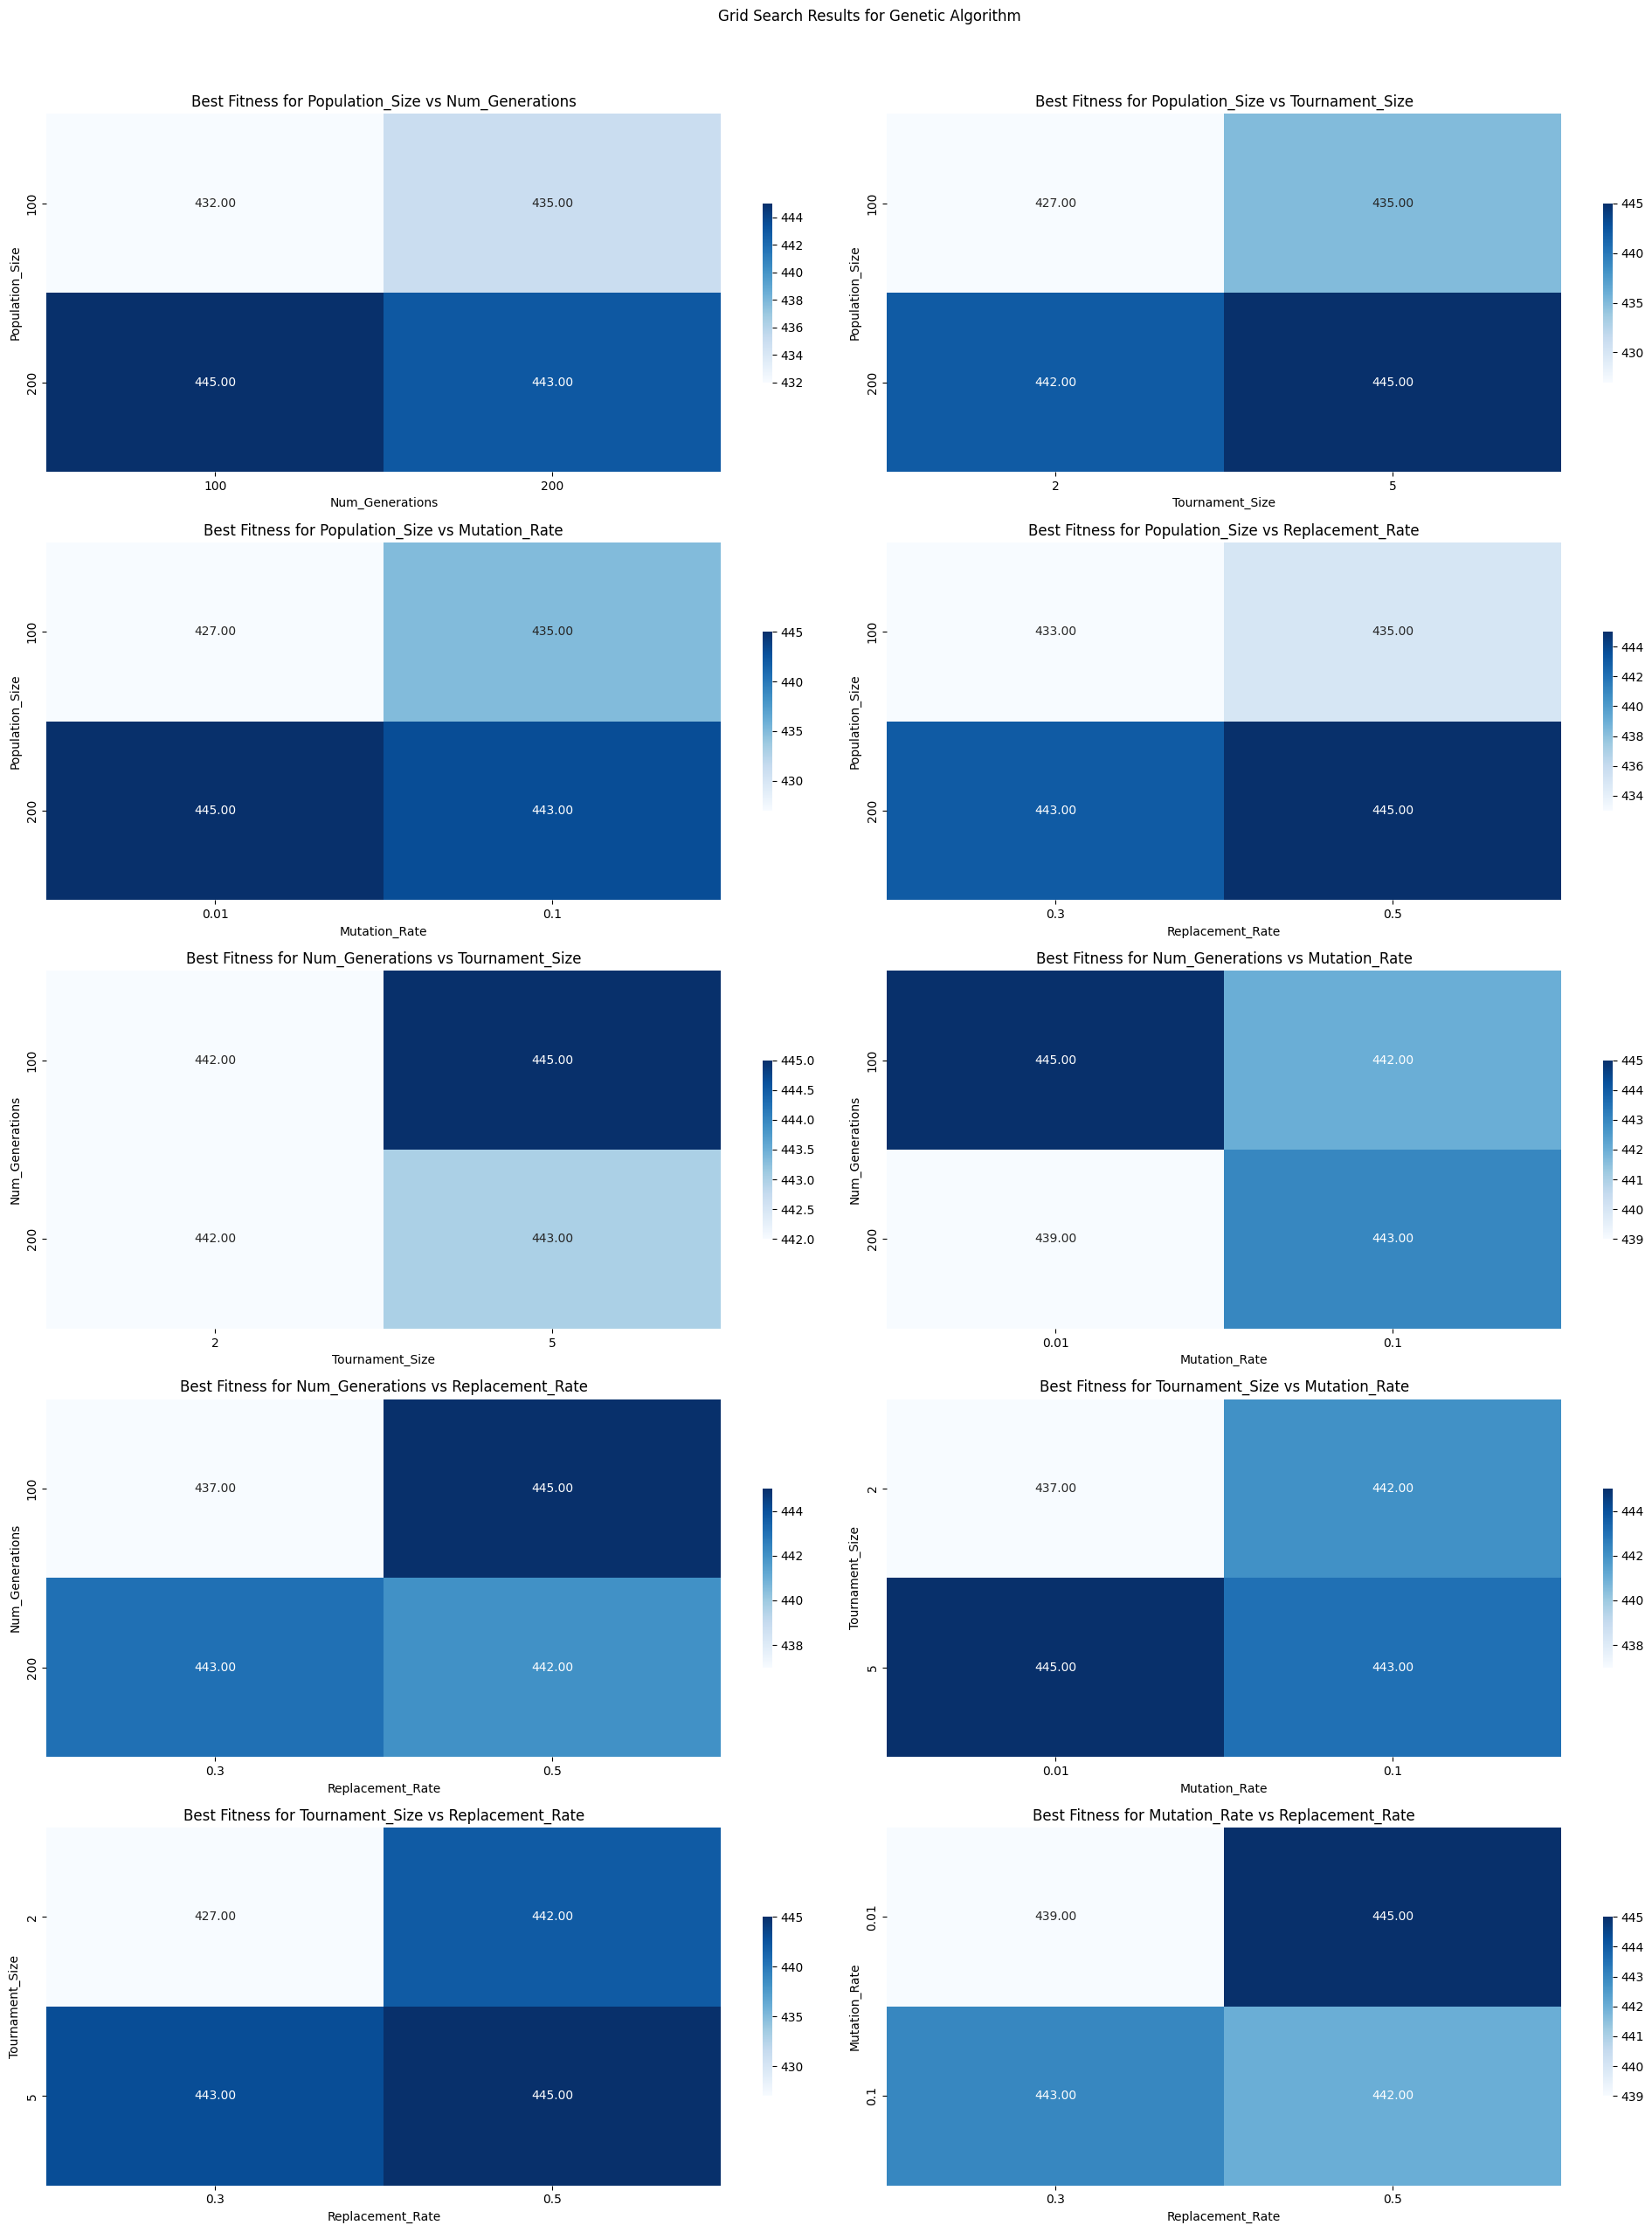

In [50]:
results_df = pd.DataFrame(results1, columns=['Population_Size', 'Num_Generations', 'Tournament_Size', 'Mutation_Rate', 'Replacement_Rate', 'Best_Fitness', 'Best_Solution'])

parameter_pairs = [
    ('Population_Size', 'Num_Generations'),
    ('Population_Size', 'Tournament_Size'),
    ('Population_Size', 'Mutation_Rate'),
    ('Population_Size', 'Replacement_Rate'),
    ('Num_Generations', 'Tournament_Size'),
    ('Num_Generations', 'Mutation_Rate'),
    ('Num_Generations', 'Replacement_Rate'),
    ('Tournament_Size', 'Mutation_Rate'),
    ('Tournament_Size', 'Replacement_Rate'),
    ('Mutation_Rate', 'Replacement_Rate')
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.suptitle('Grid Search Results for Genetic Algorithm', y=1.02)

for ax, (param1, param2) in zip(axes.flat, parameter_pairs):
    pivot_table = results_df.pivot_table(index=param1, columns=param2, values='Best_Fitness', aggfunc='max')
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f', ax=ax, cbar_kws={'shrink': 0.5})
    ax.set_title(f'Best Fitness for {param1} vs {param2}')
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)

plt.tight_layout()
plt.show()

In [8]:
best_result = results_df.loc[results_df['Best_Fitness'].idxmax()]
print("\nBest hyperparameters:")
print(f"Population Size: {best_result['Population_Size']}")
print(f"Number of Generations: {best_result['Num_Generations']}")
print(f"Tournament Size: {best_result['Tournament_Size']}")
print(f"Mutation Rate: {best_result['Mutation_Rate']}")
print(f"Replacement Rate: {best_result['Replacement_Rate']}")
print(f"Best Fitness Score: {best_result['Best_Fitness']}")

if best_result['Best_Solution']:
    best_team = best_result['Best_Solution']
    player_names = [player_name for player_name in best_team if player_name in df['Name'].values]
    final_results.append(best_result['Best_Fitness'])
    print("\nBest team:")
    print(', '.join(player_names))
else:
    print("\nNo valid best solution found.")

Best hyperparameters: 
 Population Size: 200 
 Number of Generations: 100 
 Tournament Size: 5 
 Mutation Rate: 0.01 
 Replacement Rate: 0.5 
 Best Fitness Score: 445 
 
 Best team: 
 Tyrese Haliburton, Joel Embiid, Jayson Tatum, Draymond Green, Jalen Brunson


Overall, the heatmaps indicate that larger population sizes, more generations, higher tournament sizes, moderate mutation rates, and higher replacement rates generally lead to better fitness scores. Let's see what happens with the other selection functions.

### **Roulette wheel selection**

In [ ]:
results2 = grid_search(df, param_combinations, roulette_wheel_selection)

In [51]:
for result in results2:
    population_size, num_generations, tournament_size, mutation_rate, replacement_rate, best_fitness, best_solution = result
    params = (population_size, num_generations, tournament_size, mutation_rate, replacement_rate)
    print(f"Params: {params}, Best Fitness: {best_fitness}")
    if best_solution:
        try:
            player_names = [player_name for player_name in best_solution]
            print(f"Best team: {', '.join(player_names)}")
        except KeyError as e:
            print(f"KeyError: {e}")
            print("Ensure the player names in best_solution match the DataFrame 'Name' column exists.")

Params: (100, 100, 2, 0.1, 0.3), Best Fitness: 395
Best team: Donte DiVincenzo, Nick Richards, Naji Marshall, Draymond Green, Kyrie Irving
Params: (100, 100, 2, 0.01, 0.3), Best Fitness: 404
Best team: Keita Bates-Diop, Skylar Mays, Zion Williamson, Spencer Dinwiddie, Nikola Jokic
Params: (100, 100, 5, 0.01, 0.5), Best Fitness: 412
Best team: Al Horford, Kevin Durant, Desmond Bane, Jarred Vanderbilt, Spencer Dinwiddie
Params: (100, 100, 5, 0.1, 0.3), Best Fitness: 400
Best team: Jabari Smith, Nikola Jokic, Georges Niang, Dejounte Murray, Cameron Payne
Params: (100, 100, 2, 0.1, 0.5), Best Fitness: 420
Best team: Kelly Oubre, Tobias Harris, Tyrese Haliburton, Nicolas Claxton, Jamal Murray
Params: (100, 100, 5, 0.1, 0.5), Best Fitness: 418
Best team: Obi Toppin, Devin Booker, Clint Capela, Dejounte Murray, De'Andre Hunter
Params: (100, 200, 2, 0.01, 0.3), Best Fitness: 399
Best team: Stanley Umude, Naz Reid, Trae Young, Jaylen Brown, Nassir Little
Params: (100, 200, 5, 0.01, 0.5), Best F

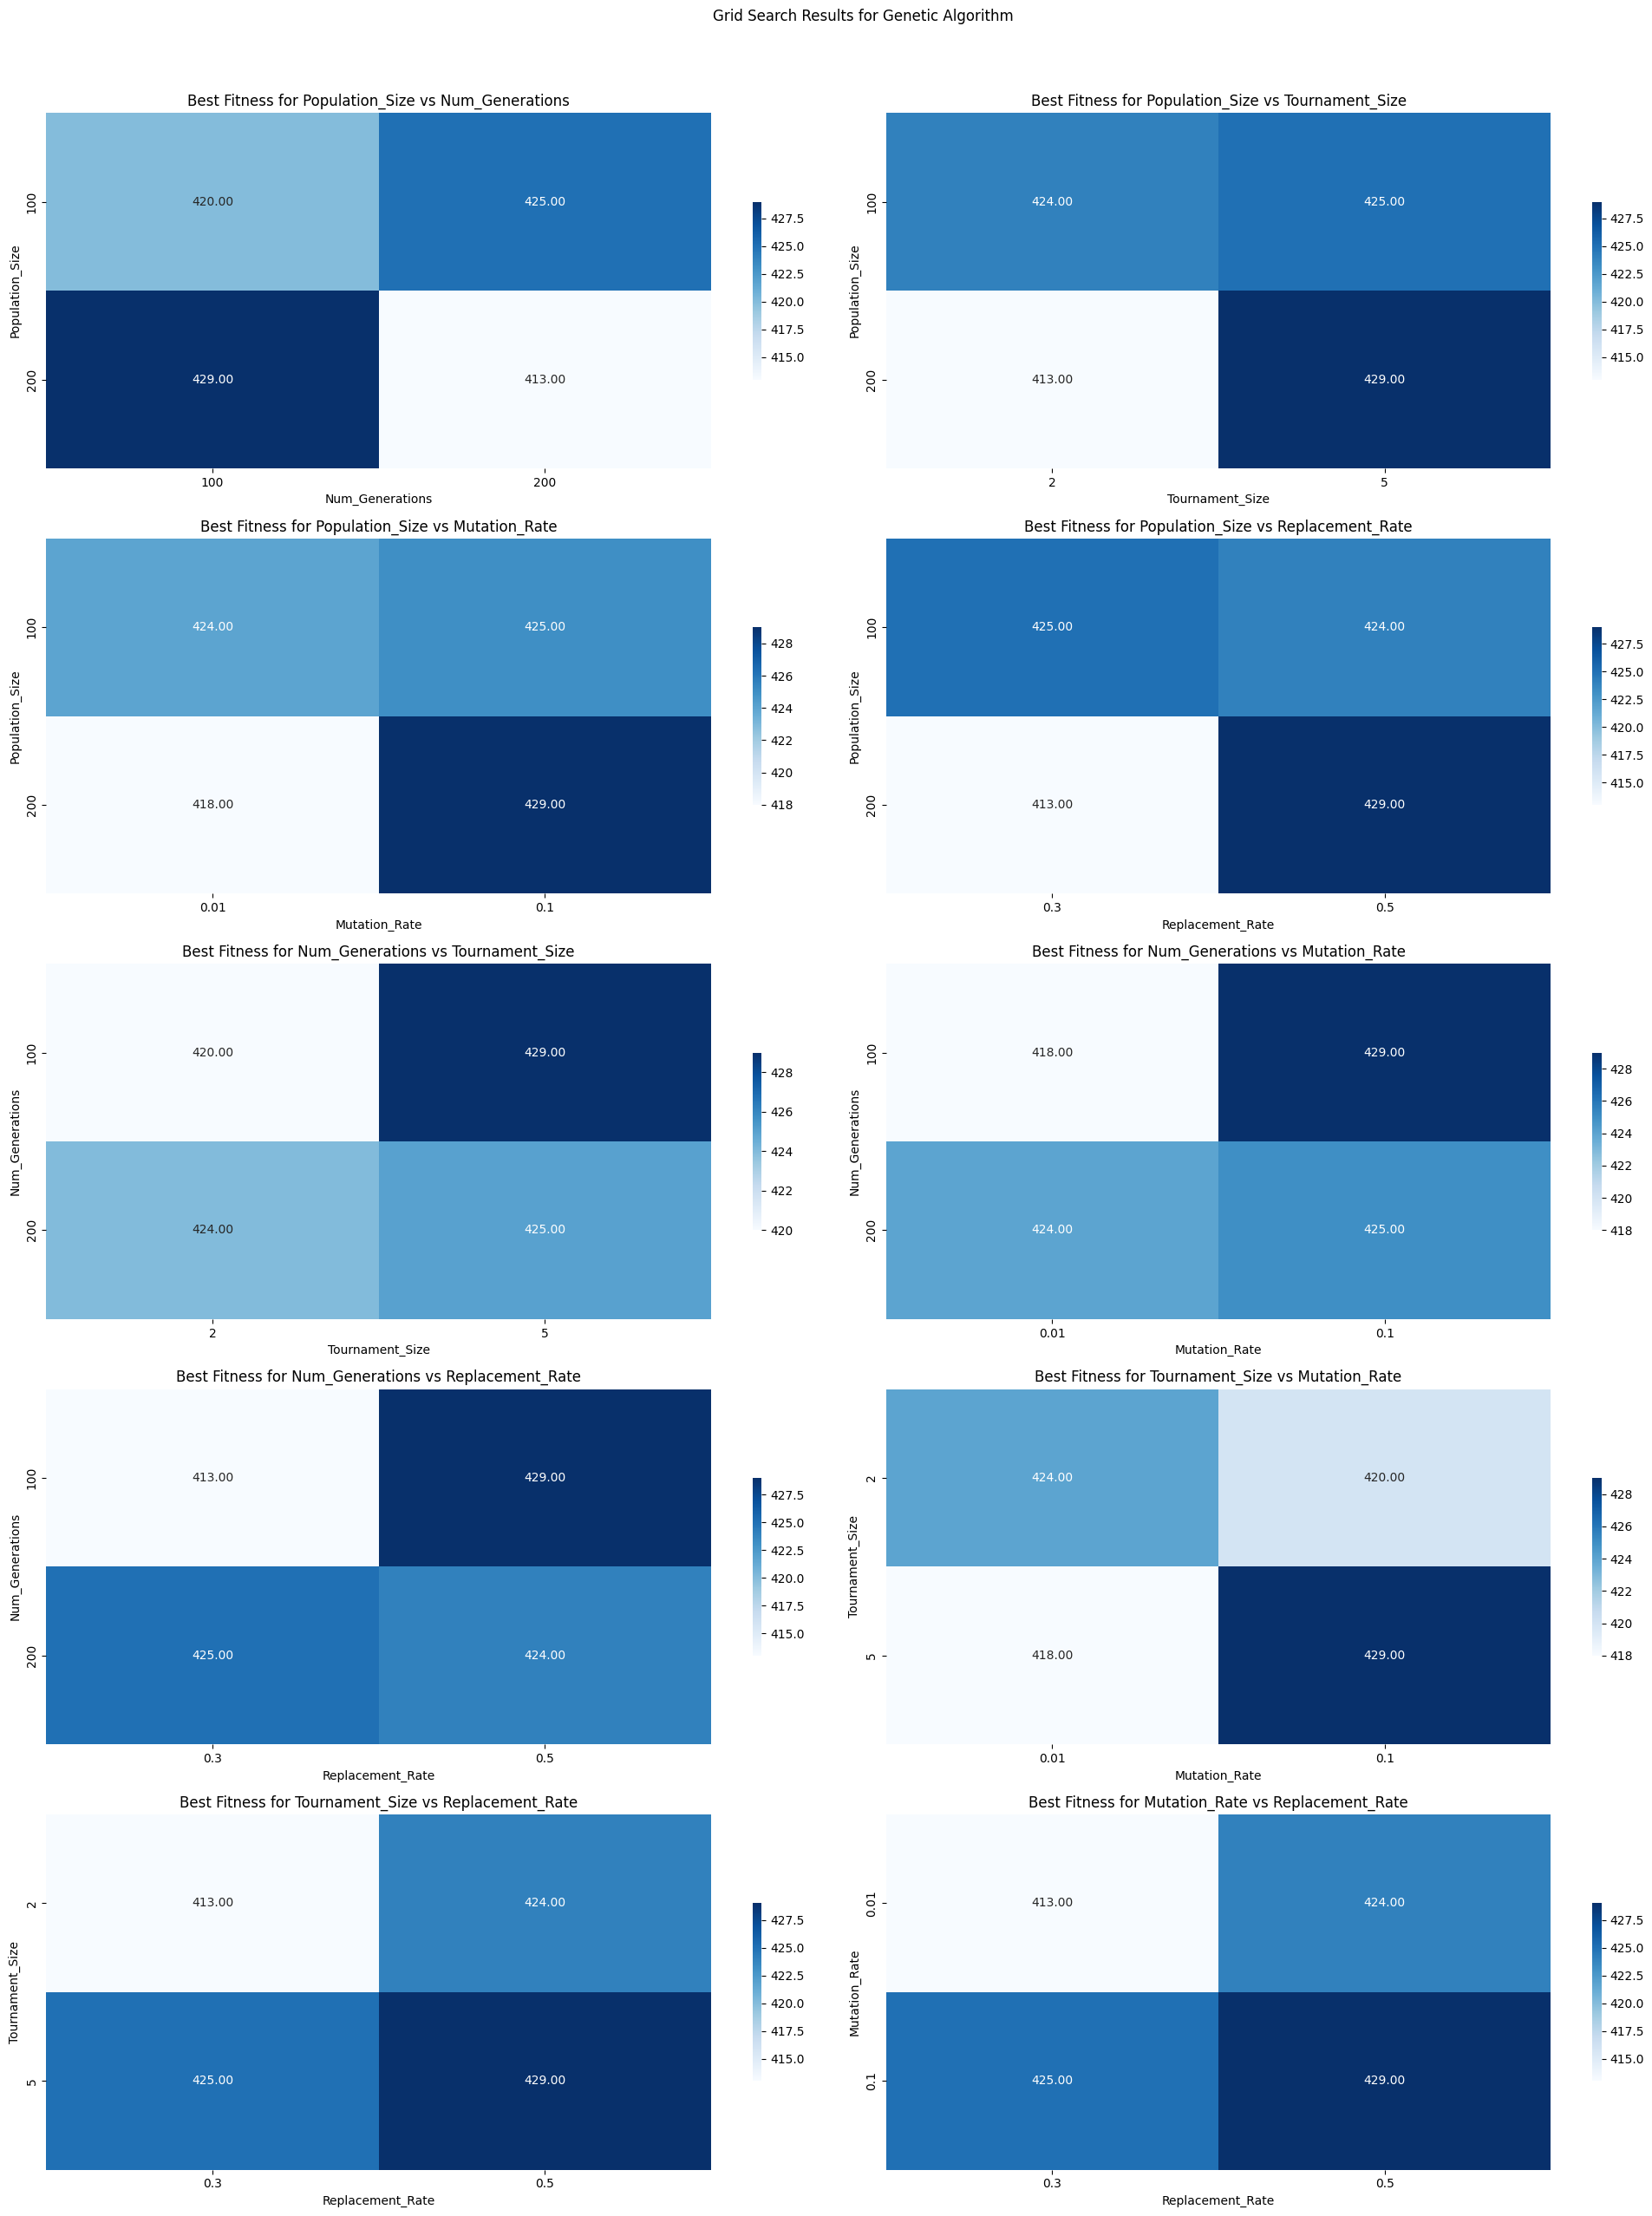

In [52]:
results_df = pd.DataFrame(results2, columns=['Population_Size', 'Num_Generations', 'Tournament_Size', 'Mutation_Rate', 'Replacement_Rate', 'Best_Fitness', 'Best_Solution'])

parameter_pairs = [
    ('Population_Size', 'Num_Generations'),
    ('Population_Size', 'Tournament_Size'),
    ('Population_Size', 'Mutation_Rate'),
    ('Population_Size', 'Replacement_Rate'),
    ('Num_Generations', 'Tournament_Size'),
    ('Num_Generations', 'Mutation_Rate'),
    ('Num_Generations', 'Replacement_Rate'),
    ('Tournament_Size', 'Mutation_Rate'),
    ('Tournament_Size', 'Replacement_Rate'),
    ('Mutation_Rate', 'Replacement_Rate')
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.suptitle('Grid Search Results for Genetic Algorithm', y=1.02)

for ax, (param1, param2) in zip(axes.flat, parameter_pairs):
    pivot_table = results_df.pivot_table(index=param1, columns=param2, values='Best_Fitness', aggfunc='max')
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f', ax=ax, cbar_kws={'shrink': 0.5})
    ax.set_title(f'Best Fitness for {param1} vs {param2}')
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)

plt.tight_layout()
plt.show()

In [9]:
best_result = results_df.loc[results_df['Best_Fitness'].idxmax()]
print("\nBest hyperparameters:")
print(f"Population Size: {best_result['Population_Size']}")
print(f"Number of Generations: {best_result['Num_Generations']}")
print(f"Tournament Size: {best_result['Tournament_Size']}")
print(f"Mutation Rate: {best_result['Mutation_Rate']}")
print(f"Replacement Rate: {best_result['Replacement_Rate']}")
print(f"Best Fitness Score: {best_result['Best_Fitness']}")

if best_result['Best_Solution']:
    best_team = best_result['Best_Solution']
    player_names = [player_name for player_name in best_team if player_name in df['Name'].values]
    final_results.append(best_result['Best_Fitness'])
    print("\nBest team:")
    print(', '.join(player_names))
else:
    print("\nNo valid best solution found.")

Best hyperparameters: 
 Population Size: 200 
 Number of Generations: 100 
 Tournament Size: 5 
 Mutation Rate: 0.1 
 Replacement Rate: 0.5 
 Best Fitness Score: 429 
 
 Best team: 
 Julius Randle, Rui Hachimura, Jonas Valanciunas, Jamal Murray, Devin Booker


This second set of heatmaps are consistent with the first ones, reaffirming that larger population sizes, more generations, higher tournament sizes, moderate mutation rates, and higher replacement rates generally lead to better fitness scores.

### **Rank selection**

In [ ]:
results3 = grid_search(df, param_combinations, rank_selection)

In [ ]:
for result in results3:
    population_size, num_generations, tournament_size, mutation_rate, replacement_rate, best_fitness, best_solution = result
    params = (population_size, num_generations, tournament_size, mutation_rate, replacement_rate)
    print(f"Params: {params}, Best Fitness: {best_fitness}")
    if best_solution:
        try:
            player_names = [player_name for player_name in best_solution]
            print(f"Best team: {', '.join(player_names)}")
        except KeyError as e:
            print(f"KeyError: {e}")
            print("Ensure the player names in best_solution match the DataFrame 'Name' column exists.")

Params: (100, 200, 2, 0.01, 0.3), Best Fitness: 355
Best team: Julius Randle, Jarace Walker, Jordan Hawkins, Shaedon Sharpe, Drew Eubanks
Params: (100, 100, 2, 0.01, 0.5), Best Fitness: 271
Best team: Payton Pritchard, Boban Marjanovic, Davis Bertans, Tyler Herro, Moritz Wagner
Params: (100, 200, 2, 0.1, 0.5), Best Fitness: 297
Best team: Lonnie Walker, Paul Reed, Anthony Davis, Jericho Sims, Kentavious Caldwell-Pope
Params: (100, 200, 2, 0.01, 0.5), Best Fitness: 275
Best team: Rudy Gobert, Lonnie Walker, Tim Hardaway Jr, Matisse Thybulle, JT Thor
Params: (100, 100, 2, 0.01, 0.3), Best Fitness: 348
Best team: Jalen Green, Alperen Sengun, Toumani Camara, Micah Potter, Stanley Umude
Params: (100, 100, 5, 0.01, 0.5), Best Fitness: 276
Best team: Donte DiVincenzo, Anthony Davis, Josh Okogie, KJ Martin, Dereck Lively
Params: (200, 100, 2, 0.01, 0.3), Best Fitness: 349
Best team: Trevelin Queen, KJ Martin, Quentin Grimes, Nikola Jovic, Goga Bitadze
Params: (200, 100, 5, 0.01, 0.5), Best Fit

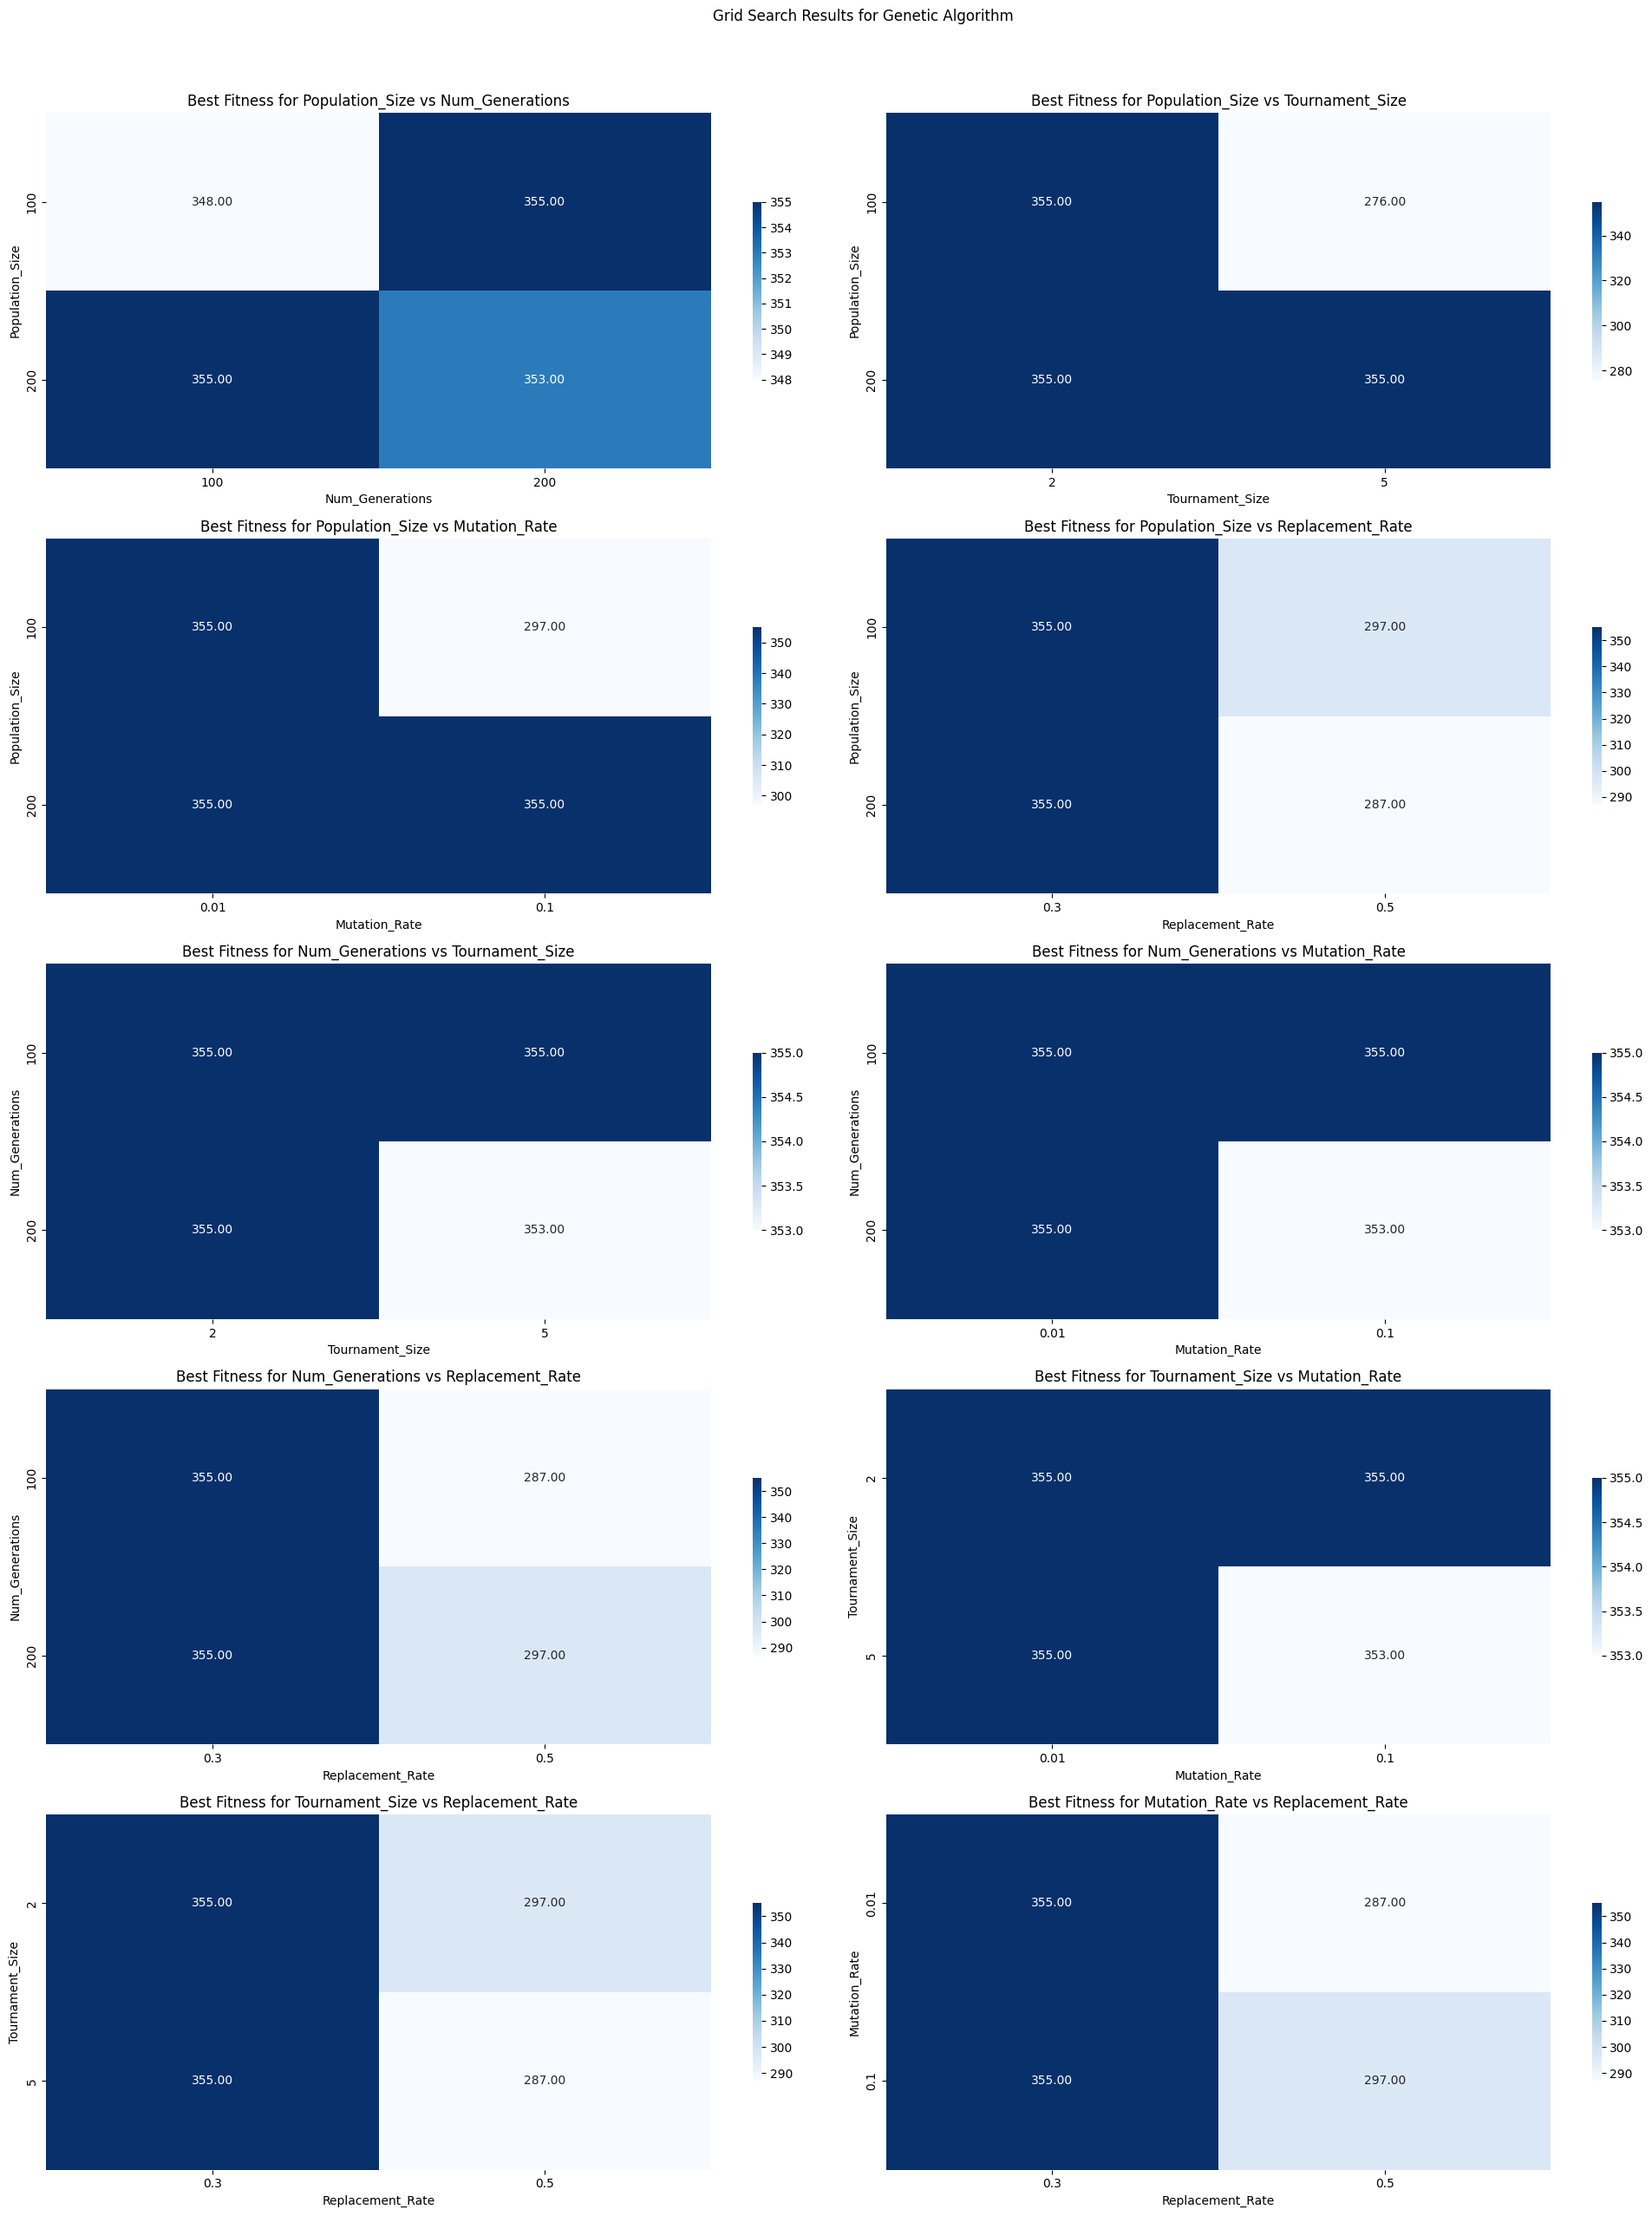

In [ ]:
results_df = pd.DataFrame(results3, columns=['Population_Size', 'Num_Generations', 'Tournament_Size', 'Mutation_Rate', 'Replacement_Rate', 'Best_Fitness', 'Best_Solution'])

parameter_pairs = [
    ('Population_Size', 'Num_Generations'),
    ('Population_Size', 'Tournament_Size'),
    ('Population_Size', 'Mutation_Rate'),
    ('Population_Size', 'Replacement_Rate'),
    ('Num_Generations', 'Tournament_Size'),
    ('Num_Generations', 'Mutation_Rate'),
    ('Num_Generations', 'Replacement_Rate'),
    ('Tournament_Size', 'Mutation_Rate'),
    ('Tournament_Size', 'Replacement_Rate'),
    ('Mutation_Rate', 'Replacement_Rate')
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.suptitle('Grid Search Results for Genetic Algorithm', y=1.02)

for ax, (param1, param2) in zip(axes.flat, parameter_pairs):
    pivot_table = results_df.pivot_table(index=param1, columns=param2, values='Best_Fitness', aggfunc='max')
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f', ax=ax, cbar_kws={'shrink': 0.5})
    ax.set_title(f'Best Fitness for {param1} vs {param2}')
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)

plt.tight_layout()
plt.show()


In [ ]:
best_result = results_df.loc[results_df['Best_Fitness'].idxmax()]
print("\nBest hyperparameters:")
print(f"Population Size: {best_result['Population_Size']}")
print(f"Number of Generations: {best_result['Num_Generations']}")
print(f"Tournament Size: {best_result['Tournament_Size']}")
print(f"Mutation Rate: {best_result['Mutation_Rate']}")
print(f"Replacement Rate: {best_result['Replacement_Rate']}")
print(f"Best Fitness Score: {best_result['Best_Fitness']}")

if best_result['Best_Solution']:
    best_team = best_result['Best_Solution']
    final_results.append(best_result['Best_Fitness'])
    print("\nBest team:")
    print(', '.join(best_team))
else:
    print("\nNo valid best solution found.")


Best hyperparameters:
Population Size: 100
Number of Generations: 200
Tournament Size: 2
Mutation Rate: 0.01
Replacement Rate: 0.3
Best Fitness Score: 355

Best team:
Julius Randle, Jarace Walker, Jordan Hawkins, Shaedon Sharpe, Drew Eubanks


This algorithm seems to have slightly different results then the other ones: lower tournament sizes, mutation rates and replacement rates lead to better results. <br>
However, it is clear that this is the selection function performing worse, with the lowest fitness score.

### **Stochastic selection**

Finally, let's see stochastic universal sampling selection with gridsearch

In [ ]:
results4 = grid_search(df, param_combinations, stochastic_universal_sampling)

In [ ]:
for result in results4:
    population_size, num_generations, tournament_size, mutation_rate, replacement_rate, best_fitness, best_solution = result
    params = (population_size, num_generations, tournament_size, mutation_rate, replacement_rate)
    print(f"Params: {params}, Best Fitness: {best_fitness}")
    if best_solution:
        try:
            player_names = [player_name for player_name in best_solution]
            print(f"Best team: {', '.join(player_names)}")
        except KeyError as e:
            print(f"KeyError: {e}")
            print("Ensure the player names in best_solution match the DataFrame 'Name' column exists.")


Params: (100, 100, 5, 0.01, 0.3), Best Fitness: 357
Best team: Gordon Hayward, Jaden Hardy, Jalen Green, Trey Lyles, DeAndre Jordan
Params: (100, 200, 2, 0.1, 0.5), Best Fitness: 273
Best team: Andre Drummond, Colby Jones, Immanuel Quickley, Cody Martin, OG Anunoby
Params: (100, 100, 2, 0.1, 0.3), Best Fitness: 418
Best team: Kyle Kuzma, Dorian Finney-Smith, Jalen Brunson, Jamal Murray, Mitchell Robinson
Params: (100, 100, 5, 0.1, 0.5), Best Fitness: 421
Best team: Larry Nance Jr, Jalen Brunson, Naz Reid, Trae Young, Jaylen Brown
Params: (100, 100, 2, 0.01, 0.3), Best Fitness: 402
Best team: Cole Anthony, Jamal Cain, Jayson Tatum, Austin Reaves, Kristaps Porzingis
Params: (100, 200, 5, 0.1, 0.5), Best Fitness: 280
Best team: Zion Williamson, Jusuf Nurkic, Sam Merrill, Jalen Smith, Doug McDermott
Params: (200, 100, 2, 0.01, 0.5), Best Fitness: 279
Best team: Max Strus, Isaiah Hartenstein, Harrison Barnes, Tyus Jones, Micah Potter
Params: (200, 100, 2, 0.1, 0.3), Best Fitness: 341
Best t

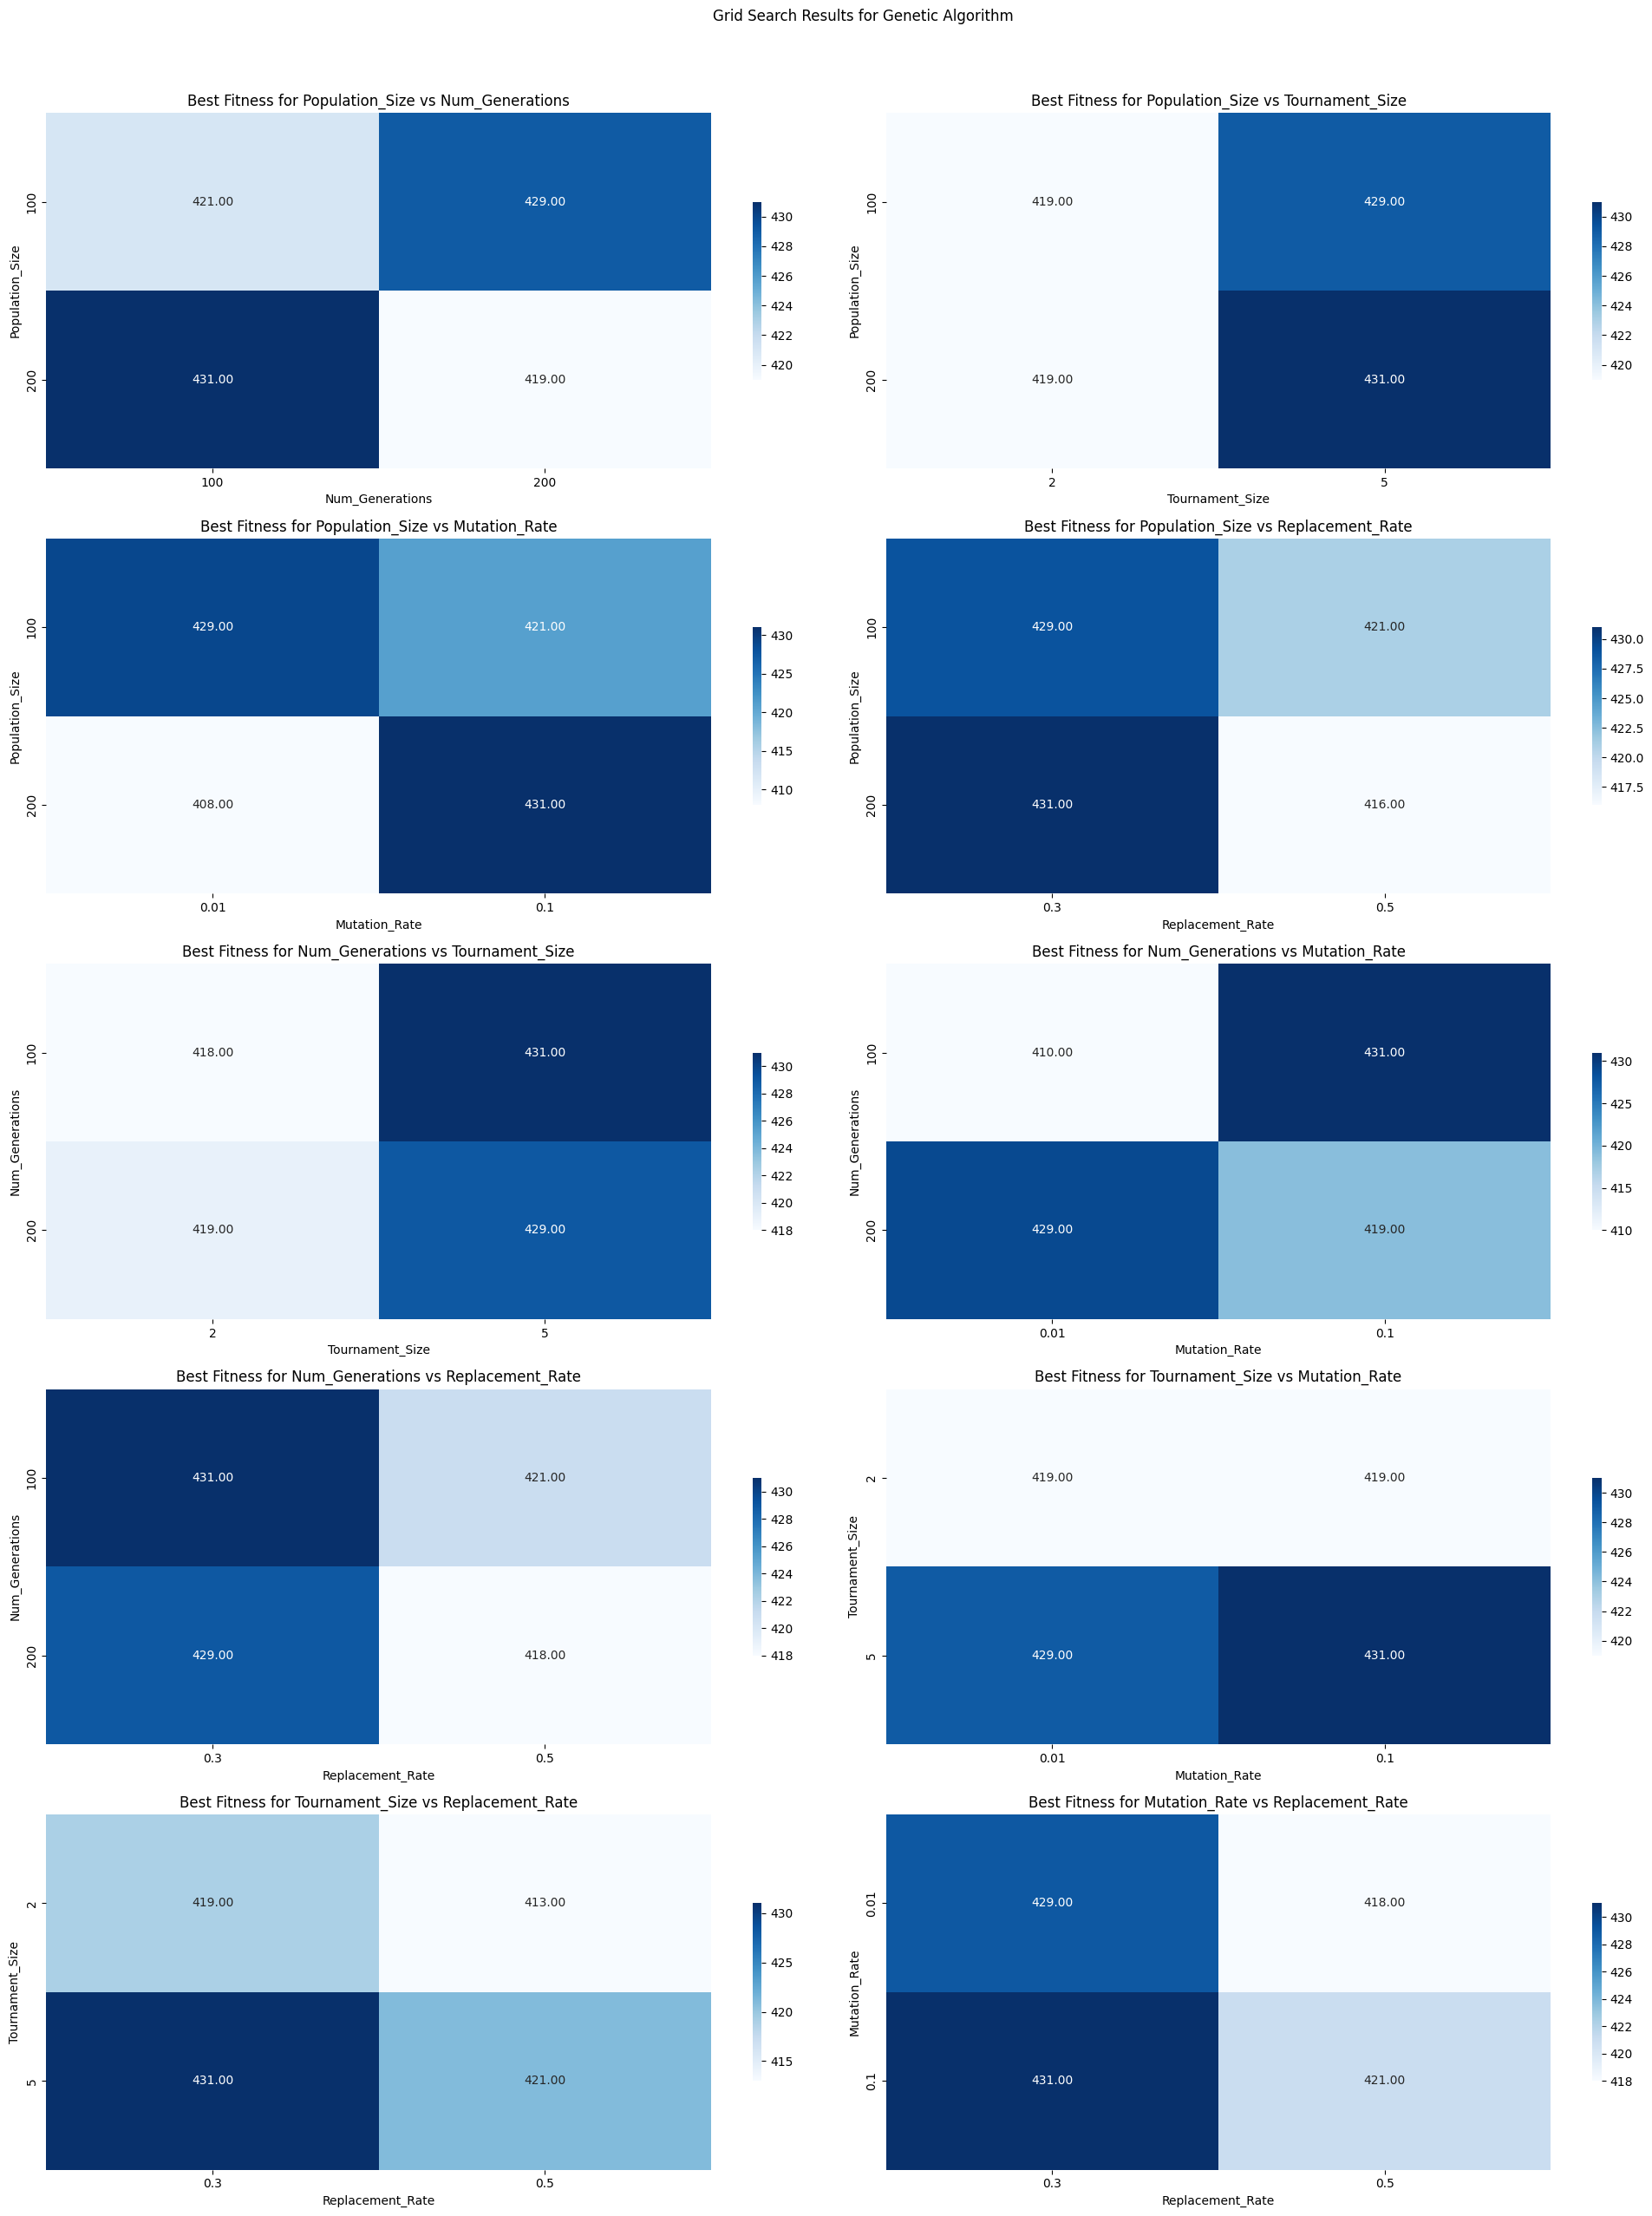

In [ ]:
results_df = pd.DataFrame(results4, columns=['Population_Size', 'Num_Generations', 'Tournament_Size', 'Mutation_Rate', 'Replacement_Rate', 'Best_Fitness', 'Best_Solution'])

parameter_pairs = [
    ('Population_Size', 'Num_Generations'),
    ('Population_Size', 'Tournament_Size'),
    ('Population_Size', 'Mutation_Rate'),
    ('Population_Size', 'Replacement_Rate'),
    ('Num_Generations', 'Tournament_Size'),
    ('Num_Generations', 'Mutation_Rate'),
    ('Num_Generations', 'Replacement_Rate'),
    ('Tournament_Size', 'Mutation_Rate'),
    ('Tournament_Size', 'Replacement_Rate'),
    ('Mutation_Rate', 'Replacement_Rate')
]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
fig.suptitle('Grid Search Results for Genetic Algorithm', y=1.02)

for ax, (param1, param2) in zip(axes.flat, parameter_pairs):
    pivot_table = results_df.pivot_table(index=param1, columns=param2, values='Best_Fitness', aggfunc='max')
    sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f', ax=ax, cbar_kws={'shrink': 0.5})
    ax.set_title(f'Best Fitness for {param1} vs {param2}')
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)

plt.tight_layout()
plt.show()

In [ ]:
best_result = results_df.loc[results_df['Best_Fitness'].idxmax()]
print("\nBest hyperparameters:")
print(f"Population Size: {best_result['Population_Size']}")
print(f"Number of Generations: {best_result['Num_Generations']}")
print(f"Tournament Size: {best_result['Tournament_Size']}")
print(f"Mutation Rate: {best_result['Mutation_Rate']}")
print(f"Replacement Rate: {best_result['Replacement_Rate']}")
print(f"Best Fitness Score: {best_result['Best_Fitness']}")

if best_result['Best_Solution']:
    best_team = best_result['Best_Solution']
    player_names = [player_name for player_name in best_team if player_name in df['Name'].values]
    final_results.append(best_result['Best_Fitness'])
    print("\nBest team:")
    print(', '.join(player_names))
else:
    print("\nNo valid best solution found.")


Best hyperparameters:
Population Size: 200
Number of Generations: 100
Tournament Size: 5
Mutation Rate: 0.1
Replacement Rate: 0.3
Best Fitness Score: 431

Best team:
Donovan Mitchell, Keita Bates-Diop, Kawhi Leonard, Jamal Murray, Mitchell Robinson


We can confirm again that our different selection functions perform differently given the parameters. <br>
However, after performing GridSearch, it is clear that the tournament selection function is the one giving a higher result overall. 

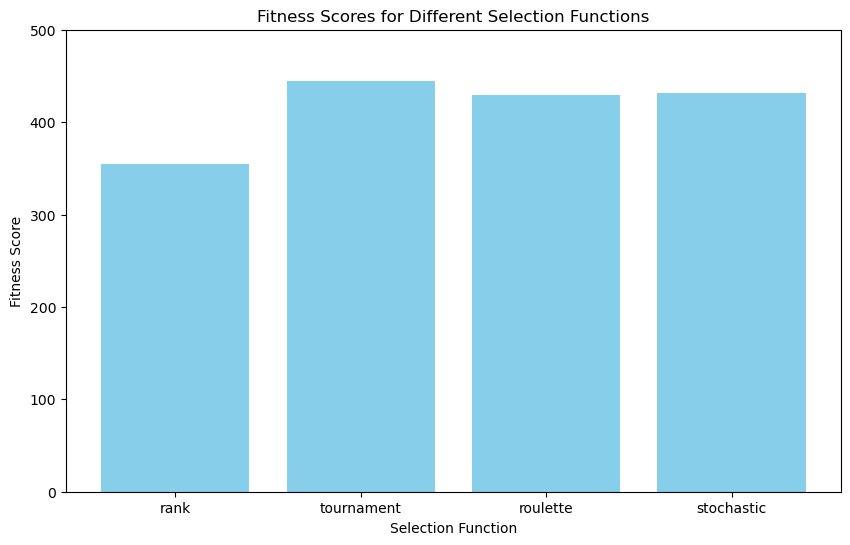

In [10]:
selection_functions = ['rank', 'tournament', 'roulette', 'stochastic']

plt.figure(figsize=(10, 6))
plt.bar(selection_functions, final_results, color='skyblue')
plt.xlabel('Selection Function')
plt.ylabel('Fitness Score')
plt.title('Fitness Scores for Different Selection Functions')
plt.ylim(0, 500) 

plt.show()

# **Conclusions**

The primary objective of this project was to optimize the selection of NBA player teams within a given salary cap using genetic algorithms. We aimed to find the best combination of players that maximizes the team’s fitness score, which is based on performance metrics while staying within budget constraints. <br>

After gathering and cleaning the NBA player data, including performance metrics and salaries, we defined the fitness function to evaluate the performance of a team based on individual player metrics. <br>

Then, we developed a genetic algorithm to explore different combinations of players, utilizing various selection functions (rank, tournament, roulette, stochastic) to maintain diversity and improve convergence. <br>
Finally, grid search was conducted to tune the genetic algorithm’s parameters, including population size, number of generations, mutation rate, and replacement rate. <br>

To summarize the results, the optimal parameter settings for the genetic algorithm were identified, yielding a highest fitness score of 445. <br>
The best-performing parameter configuration included a population size of 200, 200 generations, a tournament size of 5, a mutation rate of 0.01, and a replacement rate of 0.5. <br>

The results validate the effectiveness of using genetic algorithms for team selection in sports, demonstrating that well-tuned genetic algorithms can effectively navigate large search spaces and find optimal solutions within constraints. <br>

However, quality of the final team selection is highly dependent on the accuracy and relevance of the input data, including player performance metrics and salary information. <br>
The genetic algorithm’s performance is influenced by the chosen fitness function, which may need adjustment to better reflect real-world considerations and strategic goals. <br>

Future work might include: <br>
- Expanding GridSearch implementation: include more parameters <br>
- Enhance the Fitness Function: incorporate additional factors such as team chemistry, player injury history, and future potential to create a more comprehensive evaluation of team performance. <br>
- Expand Data Sources: include more detailed and updated data on player performance and salaries to refine the accuracy of the algorithm’s selections; also, include other players <br>
- Try to implement it with a different team size